In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Read data

In [36]:
cities = ['Indianapolis', 'Portland', 'Seattle', 'Vancouver', 'Boston', 'Chicago', 'Albuquerque', 'Philadelphia', 'New York', 'Pittsburgh']

In [37]:
X = pd.DataFrame()
X['humidity'] = pd.read_csv('kaggle_data/humidity.csv')[cities].values[:,1:].flatten().astype(np.float32)
X['temperature'] = pd.read_csv('kaggle_data/temperature.csv')[cities].values[:,1:].flatten().astype(np.float32)
X['temperature'] -= 273.15
X['pressure'] = pd.read_csv('kaggle_data/pressure.csv')[cities].values[:,1:].flatten().astype(np.float32)
X['label'] = pd.read_csv('kaggle_data/weather_description.csv')[cities].values[:,1:].flatten()

In [38]:
rain = ['light rain', 'moderate rain', 'heavy intensity rain', 'light intensity drizzle', 'drizzle', 'proximity shower rain', 'proximity thunderstorm', 'very heavy rain']
clouds = ['broken clouds', 'scattered clouds', 'overcast clouds', 'mist', 'haze', 'fog']
snow = ['light snow', 'snow', 'heavy snow', 'light shower snow']
clear = ['sky is clear', 'few clouds']

In [39]:
#Reduce number of categories
X.loc[X.label.isin(rain), 'label'] = 'Rain'
X.loc[X.label.isin(clouds), 'label'] = 'Clouds'
X.loc[X.label.isin(snow), 'label'] = 'Snow'
X.loc[X.label.isin(clear), 'label'] = 'Clear'

# Shift label by one to predict next hour
X.label = X.label.shift(1)
X = X.dropna()

# Discard unassigned timesteps
X = X[((X.label == 'Rain') | (X.label == 'Clouds') | (X.label == 'Snow') | (X.label == 'Clear')) & (X.pressure > 975) ]

In [40]:
labels, uniques = X['label'].factorize()
X['label'] = labels

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X.values[:,:3], X.values[:,3], shuffle=False, test_size=0.3)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, shuffle=False, test_size=0.5)

In [42]:
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train = (X_train - X_mean) / X_std
X_test = (X_test - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

In [43]:
X_mean

array([  71.06214581,   10.44727886, 1020.73639297])

In [44]:
X_std

array([21.15321648,  9.32877858, 10.90652208])

<Figure size 1440x1080 with 0 Axes>

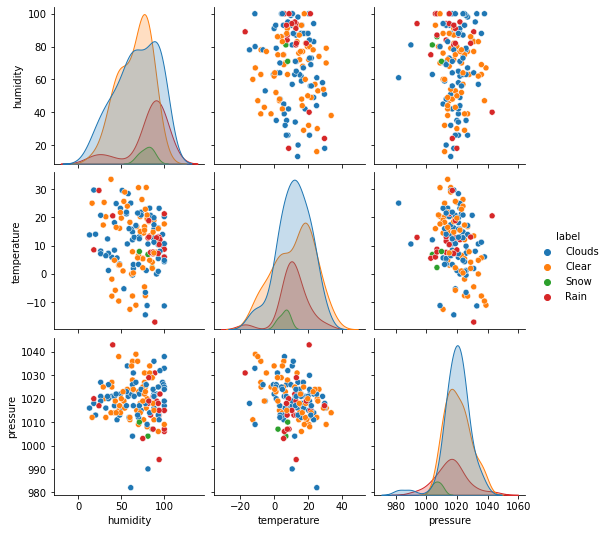

In [45]:
plt.figure(figsize=(20,15))
pl = X.sample(150)
pl.label = uniques[pl.label]
sns.pairplot(pl, hue='label')
plt.savefig('weather_distribution.png')

# Train model

In [46]:
model = keras.models.Sequential()
model.add(layers.Input(shape=(3,)))
model.add(layers.Dense(16, activation='relu', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Dense(16, activation='relu', use_bias=False))
model.add(layers.BatchNormalization())
model.add(layers.Dense(len(uniques), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [47]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Epoch 1/3
8504/8504 [==============================] - 11s 1ms/step - loss: 1.0978 - accuracy: 0.4433 - val_loss: 1.0644 - val_accuracy: 0.4559
Epoch 2/3
8504/8504 [==============================] - 11s 1ms/step - loss: 1.0830 - accuracy: 0.4474 - val_loss: 1.0634 - val_accuracy: 0.4604
Epoch 3/3
8504/8504 [==============================] - 12s 1ms/step - loss: 1.0816 - accuracy: 0.4492 - val_loss: 1.0630 - val_accuracy: 0.4580


In [48]:
model.evaluate(X_val, y_val)

1823/1823 [==============================] - 1s 704us/step - loss: 1.0218 - accuracy: 0.45400s - loss: 1.0443 


[1.0217528343200684, 0.4539685845375061]

In [49]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                48        
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64        
_________________________________________________________________
dense_5 (Dense)              (None, 16)                256       
_________________________________________________________________
batch_normalization_4 (Batch (None, 16)                64        
_________________________________________________________________
dense_6 (Dense)              (None, 16)                256       
_________________________________________________________________
batch_normalization_5 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 4)                

In [50]:
model.save('dense')

INFO:tensorflow:Assets written to: dense/assets


INFO:tensorflow:Assets written to: dense/assets


In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [52]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]

def representative_dataset_gen():
    for i in range(1000):
    # Get sample input data as a numpy array in a method of your choosing.
        yield([X_train[i][np.newaxis,:].astype(np.float32)])
        
converter.representative_dataset = representative_dataset_gen

In [53]:
model_tflite = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpai6bjkog/assets


INFO:tensorflow:Assets written to: /tmp/tmpai6bjkog/assets


In [54]:
with open('model.tflite', 'wb') as f:
    f.write(model_tflite)